In [13]:
import Pkg
packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
]

Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [14]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 

Running continuation for gamma = 0.0 ...
Running continuation for gamma = 0.2 ...
Running continuation for gamma = 1.0 ...


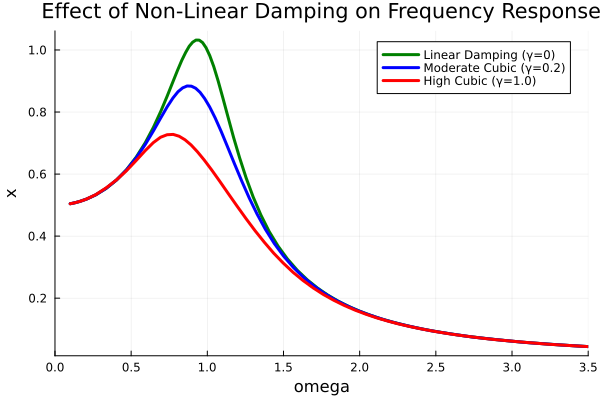

In [15]:
# 1. Define the Nonlinear ODE Function
function driven_oscillator!(du, u, p, t)
    # u[1] = x (position)
    # u[2] = v (velocity)
    du[1] = u[2]
    
    # Equation: m*x'' + c*x' + gamma*(x')^3 + k*x + alpha*x^3 = F*cos(omega*t)
    force_driving = p.F * cos(p.omega * t)
    damping_term  = p.c * u[2] + p.gamma * (u[2]^3)  # cubic damping
    stiffness_term = p.k * u[1] + p.alpha * (u[1]^3) # cubic stiffness
    
    du[2] = (force_driving - damping_term - stiffness_term) / p.m
end

# 2. Base Parameter Set (Starting with Linear Case)
par_osc = (m = 1.0, k = 1.0, c = 0.5, alpha = 0, gamma = 0.0, F = 0.5, omega = 0.1)

# 3. Poincaré Map
function poincare_map(u, p)
    omega = p.omega
    T = 2π / abs(omega)
    
    prob = ODEProblem(driven_oscillator!, u, (0.0, T), p)
    sol = solve(prob, RK4(), reltol=1e-9, abstol=1e-9, save_everystep=false)
    return sol[end] - u
end

# 4. Continuation Options
opts = ContinuationPar(
    p_min = 0.1, 
    p_max = 3.5,       
    ds = 0.01,         
    dsmax = 0.05,
    max_steps = 2000,
    detect_bifurcation = 0, 
    newton_options = NewtonPar(tol = 1e-8, max_iterations = 20) 
)

# 5. Function to run the analysis for a specific Gamma
function run_analysis(gamma_val, label_text, color_sym)
    par_current = setproperties(par_osc, gamma = gamma_val)
    
    # Initial guess
    u0 = [0.1, 0.0] 

    # Define problem
    prob = BifurcationProblem(poincare_map, u0, par_current, (@optic _.omega);
        record_from_solution = (x, p; k...) -> begin

            current_omega = (p isa Real) ? p : p.omega
            p_full = setproperties(par_current, omega = Float64(current_omega))
            
            # Integrate one cycle to find max amplitude
            T = 2π / p_full.omega
            prob_rec = ODEProblem(driven_oscillator!, x, (0.0, T), p_full)
            sol_rec = solve(prob_rec, Tsit5(), reltol=1e-8, abstol=1e-8)
            return maximum(abs.(sol_rec[1, :]))
        end
    )
    
    # Run Continuation
    println("Running continuation for gamma = $gamma_val ...")
    branch = continuation(prob, PALC(), opts)
    
    return branch
end

# 6. Run for different Damping scenarios
# Case 1: Linear Damping (gamma = 0)
branch1 = run_analysis(0.0, "Linear (γ=0)", :green)

# Case 2: Mid Nonlinear Damping
branch2 = run_analysis(0.2, "Moderate (γ=0.2)", :blue)

# Case 3: High Nonlinear Damping
branch3 = run_analysis(1.0, "High (γ=1.0)", :red)

# 7. Plotting the Comparison
p = plot(branch1, 
    label = "Linear Damping (γ=0)", 
    lw = 3, color = :green,
    title = "Effect of Non-Linear Damping on Frequency Response",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Max Amplitude |x|",
    xlims = (0, 3.5),
    legend = :topright
)

plot!(p, branch2, label = "Moderate Cubic (γ=0.2)", lw = 3, color = :blue)
plot!(p, branch3, label = "High Cubic (γ=1.0)", lw = 3, color = :red)

display(p)